In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
pwd

'C:\\Users\\mnan\\Desktop\\viz\\house_pred_ML'

In [3]:
train = pd.read_csv("data/train.csv",index_col = 0)
test = pd.read_csv("data/test.csv",index_col = 0)

In [6]:
train.shape

(1460, 81)

In [7]:
test.shape

(1459, 80)

In [164]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
pd.DataFrame(train.isnull().sum(),columns = ['missingVal']).query('missingVal>0').sort_values(by = 'missingVal',ascending = False)

,missingVal
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81
GarageQual,81


In [5]:
pd.DataFrame(test.isnull().sum(),columns = ['missingVal']).query('missingVal>0').sort_values(by = 'missingVal',ascending = False)

,missingVal
PoolQC,1456
MiscFeature,1408
Alley,1352
Fence,1169
FireplaceQu,730
LotFrontage,227
GarageCond,78
GarageYrBlt,78
GarageQual,78
GarageFinish,78


In [4]:
col_drop = list(pd.DataFrame(train.isnull().sum(),columns = ['missingVal'])
                .query('missingVal>0')
                .sort_values(by = 'missingVal',ascending = False)
                .index[:4])
print('Drop columns: %s because they contain too many missing values'%col_drop)

Drop columns: ['PoolQC', 'MiscFeature', 'Alley', 'Fence'] because they contain too many missing values


In [5]:
## drop cols
for col in col_drop:
    train = train.drop(col, 1)
    test = test.drop(col,1)
    
train = train.drop('Utilities', 1) ## no data variety in Utilities
test = test.drop('Utilities', 1)
train = train.drop('GarageYrBlt',1) ## 'GarageYrBlt' duplicate with YearBuilt
test = test.drop('GarageYrBlt',1)

In [6]:
print('Now we have %d features'%test.shape[1])

Now we have 73 features


In [7]:
## validate
train.shape[1]-test.shape[1]==1

True

## Handle Missing Value

In [84]:
#other cols containing missing values
col_miss = list(pd.DataFrame(train.isnull().sum(),columns = ['missingVal'])
                .query('missingVal>0')
                .sort_values(by = 'missingVal',ascending = False)
                .index[5:])
print('dtype for col:')
for col in col_miss:
    print(dict(train.dtypes)[col],':',col)

dtype for col:
object : GarageCond
object : BsmtExposure
object : BsmtFinType2
object : BsmtQual
object : BsmtCond
object : BsmtFinType1
object : MasVnrType
float64 : MasVnrArea
object : Electrical


In [241]:
test.ix[np.isnan(test['BsmtFullBath'])].filter(regex = 'Bsmt*',axis = 1)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2189,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN


In [242]:
num_col_miss = ['LotFrontage','GarageYrBlt','MasVnrArea']
cate_col_miss = [x for x in col_miss if x not in num_col_miss]
print('Three numeric cols contain missing values, they are %s \n%d categorical columns have missing values, they are %s'
     %(num_col_miss,len(cate_col_miss),cate_col_miss))

Three numeric cols contain missing values, they are ['LotFrontage', 'GarageYrBlt', 'MasVnrArea'] 
8 categorical columns have missing values, they are ['GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrType', 'Electrical']


In [38]:
from collections import Counter
print(Counter(list(test['GarageCars'])))
print(Counter(list(train['MiscVal'])))

Counter({'2.0': 770, '1.0': 407, '3.0': 193, '0.0': 77, '4.0': 11, '5.0': 1})
Counter({0: 1408, 400: 11, 500: 8, 700: 5, 450: 4, 2000: 4, 600: 4, 480: 2, 1200: 2, 8300: 1, 620: 1, 3500: 1, 15500: 1, 2500: 1, 1400: 1, 1150: 1, 54: 1, 560: 1, 1300: 1, 350: 1, 800: 1})


In [22]:
# only NA in 'MasVnrType', 'Electrical' means missing value indeed
def false_na(train):
    train['GarageType']=train['GarageType'].replace({np.nan:'noGarage'})
    train['GarageFinish']=train['GarageFinish'].replace({np.nan:'noGarage'})
    train['GarageQual']=train['GarageQual'].replace({np.nan:'noGarage'})
    train['GarageCars']=train['GarageCars'].replace({np.nan:0})
    train['GarageArea']=train['GarageArea'].replace({np.nan:'0'})
    train['GarageCond']=train['GarageCond'].replace({np.nan:'noGarage'})
    #train['GarageYrBlt']=train['GarageYrBlt'].replace({np.nan:train['YearBuilt']})
    #train['GarageYrBlt'] = train['GarageYrBlt'].astype(str)
    
    train['BsmtExposure']=train['BsmtExposure'].replace({np.nan:'noBasement'})
    train['BsmtFinType2']=train['BsmtFinType2'].replace({np.nan:'noBasement'})
    train['BsmtFinType1']=train['BsmtFinType1'].replace({np.nan:'noBasement'})
    train['BsmtCond']=train['BsmtCond'].replace({np.nan:'noBasement'})
    train['BsmtQual']=train['BsmtQual'].replace({np.nan:'noBasement'})
    train['TotalBsmtSF']=train['TotalBsmtSF'].replace({np.nan:0})
    train['BsmtFinSF1']=train['BsmtFinSF1'].replace({np.nan:0})
    train['BsmtFinSF2']=train['BsmtFinSF2'].replace({np.nan:0})
    train['BsmtUnfSF']=train['BsmtUnfSF'].replace({np.nan:0})
    train['TotalBsmtSF']=train['TotalBsmtSF'].replace({np.nan:0})
    train['BsmtHalfBath']=train['BsmtHalfBath'].replace({np.nan:0})
    train['BsmtFullBath']=train['BsmtFullBath'].replace({np.nan:0})

    train['FireplaceQu']=train['FireplaceQu'].replace({np.nan:'noFireplace'})
    train['MasVnrType']=train['MasVnrType'].replace({np.nan:'noMasonryVeneer'})
    train['MasVnrArea']=train['MasVnrArea'].replace({np.nan:0})  
    train['MSZoning']=train['MSZoning'].replace({np.nan:'RL'})  
    train['Functional']=train['Functional'].replace({np.nan:'Typ'})  
    train['Exterior1st']=train['Exterior1st'].replace({np.nan:'VinylSd'})  
    train['Exterior2nd']=train['Exterior2nd'].replace({np.nan:'VinylSd'})  
    train['Electrical']=train['Electrical'].replace({np.nan:'SBrkr'})  
    train['SaleType']=train['SaleType'].replace({np.nan:'WD'}) 
    train['KitchenQual']=train['KitchenQual'].replace({np.nan:'TA'})  
    
    train['LotFrontage']=train['LotFrontage'].replace({np.nan:train['LotFrontage'].median()}) 
    
    #train['MSSubClass'] = train['MSSubClass'].astype(str)
    #train['OverallQual'] = train['OverallQual'].astype(str)
    #train['OverallCond'] = train['OverallCond'].astype(str)
    #train['YearBuilt'] = train['YearBuilt'].astype(str)
    #train['OverallCond'] = train['OverallCond'].astype(str)
    #train['YearRemodAdd'] = train['YearRemodAdd'].astype(str)
    #train['MoSold'] = train['MoSold'].astype(str)
    #train['YrSold'] = train['YrSold'].astype(str)
    #train['BsmtFullBath'] = train['BsmtFullBath'].astype(str)
    #train['BsmtHalfBath'] = train['BsmtHalfBath'].astype(str)
    #train['FullBath'] = train['FullBath'].astype(str)
    #train['HalfBath'] = train['HalfBath'].astype(str)
    #train['BedroomAbvGr'] = train['BedroomAbvGr'].astype(str)
    #train['KitchenAbvGr'] = train['KitchenAbvGr'].astype(str)
    #train['TotRmsAbvGrd'] = train['TotRmsAbvGrd'].astype(str)
    #train['Fireplaces'] = train['Fireplaces'].astype(str)

    
# assign missing vals in Functional to 'Typ'
# assign missing vals in Exterior1st to 'VinylSd'
# assign missing vals in Exterior2nd to 'VinylSd'
# assign missing vals in 'Electrical' to 'SBrkr'
# assign missing vals in 'SaleType' to 'WD'
    return train
# so two categorical cols ('MasVnrType', 'Electrical') contain missing value 
# and three numeric cols contain missing value

In [23]:
test = false_na(test)
train = false_na(train)
## validate
train.shape[1]-test.shape[1]==1

True

In [9]:
pd.DataFrame(train.isnull().sum(),columns = ['missingVal']).query('missingVal>0').sort_values(by = 'missingVal',ascending = False)

,missingVal


In [10]:
pd.DataFrame(test.isnull().sum(),columns = ['missingVal']).query('missingVal>0').sort_values(by = 'missingVal',ascending = False)

,missingVal


** Now we've handled all missing values in both test and train set **

Belows are exploration codes. We don't need them for actual data transformation

In [24]:
## check data types
df_dtypes = pd.DataFrame(train.dtypes,columns=['train_dtypes']).join(pd.DataFrame(test.dtypes,columns=['test_dtypes']))
df_dtypes_diff = df_dtypes.ix[df_dtypes['train_dtypes'] != df_dtypes['test_dtypes']]

## GarageCars and GarageArea
## int64 to float

In [25]:
print(df_dtypes_diff.index[:6])
df_dtypes_diff

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath'],
      dtype='object')


,train_dtypes,test_dtypes
BsmtFinSF1,int64,float64
BsmtFinSF2,int64,float64
BsmtUnfSF,int64,float64
TotalBsmtSF,int64,float64
BsmtFullBath,int64,float64
BsmtHalfBath,int64,float64
GarageCars,int64,float64
GarageArea,int64,object
SalePrice,int64,NaN


In [26]:
for col in df_dtypes_diff.index[:6]:
    train[col] = train[col].astype('float')
train['GarageCars'] = train['GarageCars'].astype('float')
#train['GarageCars'] = train['GarageCars'].astype('str')
#test['GarageCars'] = test['GarageCars'].astype('str')
test['GarageArea'] = test['GarageArea'].astype('float')
train['GarageArea'] = train['GarageArea'].astype('float')

# check
df_dtypes0 = pd.DataFrame(train.dtypes,columns=['train_dtypes']).join(pd.DataFrame(test.dtypes,columns=['test_dtypes']))
df_dtypes0.ix[df_dtypes0['train_dtypes'] != df_dtypes0['test_dtypes']]

,train_dtypes,test_dtypes
SalePrice,int64,NaN


In [13]:
## validate
train.shape[1]-test.shape[1]==1

True

In [11]:
## let's check all categorical features
categorical_fea = df_dtypes0[df_dtypes0['test_dtypes']=='object'].index
extra_fea_test = []

for col in categorical_fea[:-2]:
    print(col)
    print(train[col].unique())
    print(test[col].unique())
    if not test[col].unique() in train[col].unique():
        print('column %s contrain extra values in test set'% col)
        extra_fea_test.append(col)
    print('---------------------')

MSZoning
['RL' 'RM' 'C (all)' 'FV' 'RH']
['RH' 'RL' 'RM' 'FV' 'C (all)' nan]
column MSZoning contrain extra values in test set
---------------------
Street
['Pave' 'Grvl']
['Pave' 'Grvl']
---------------------
LotShape
['Reg' 'IR1' 'IR2' 'IR3']
['Reg' 'IR1' 'IR2' 'IR3']
---------------------
LandContour
['Lvl' 'Bnk' 'Low' 'HLS']
['Lvl' 'HLS' 'Bnk' 'Low']
---------------------
LotConfig
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
['Inside' 'Corner' 'FR2' 'CulDSac' 'FR3']
---------------------
LandSlope
['Gtl' 'Mod' 'Sev']
['Gtl' 'Mod' 'Sev']
---------------------
Neighborhood
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
['NAmes' 'Gilbert' 'StoneBr' 'BrDale' 'NPkVill' 'NridgHt' 'Blmngtn'
 'NoRidge' 'Somerst' 'SawyerW' 'Sawyer' 'NWAmes' 'OldTown' 'BrkSide'
 'ClearCr' 'SWISU' 'Edwards' 'CollgCr

C:\Users\mnan\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
C:\Users\mnan\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.


In [12]:
extra_fea_test

['MSZoning',
 'Neighborhood',
 'Condition2',
 'HouseStyle',
 'RoofMatl',
 'Exterior1st',
 'BsmtFinType2',
 'Heating',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageQual']

In [27]:
df_dtypes = pd.DataFrame(train.dtypes,columns = ['dtypes'])
numeric_cols = df_dtypes[df_dtypes['dtypes']!='object'].index
cate_cols = df_dtypes[df_dtypes['dtypes']=='object'].index

In [28]:
print("We have %d numeric cols and %d categorical cols." %(len(numeric_cols),len(cate_cols)))
print(numeric_cols)

We have 36 numeric cols and 38 categorical cols.
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [15]:
print(cate_cols)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


In [29]:
for col in cate_cols:
    le = preprocessing.LabelEncoder()
    le.fit(train[col].append(test[col]))
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

In [30]:
#check dtypes
def check_dtype(df):
    for col in df.columns:
        df[col] = df[col].astype('float')
    print("Cols in df are all numerical is %s"%(sum([df[col].dtypes=='float'
                                                      for col in df.columns])==len(df.columns)))
    return df

train = check_dtype(train)
test = check_dtype(test)

Cols in df are all numerical is True
Cols in df are all numerical is True


In [31]:
print('Now we have %d features and they are all numerical'%len(test.columns))

Now we have 73 features and they are all numerical


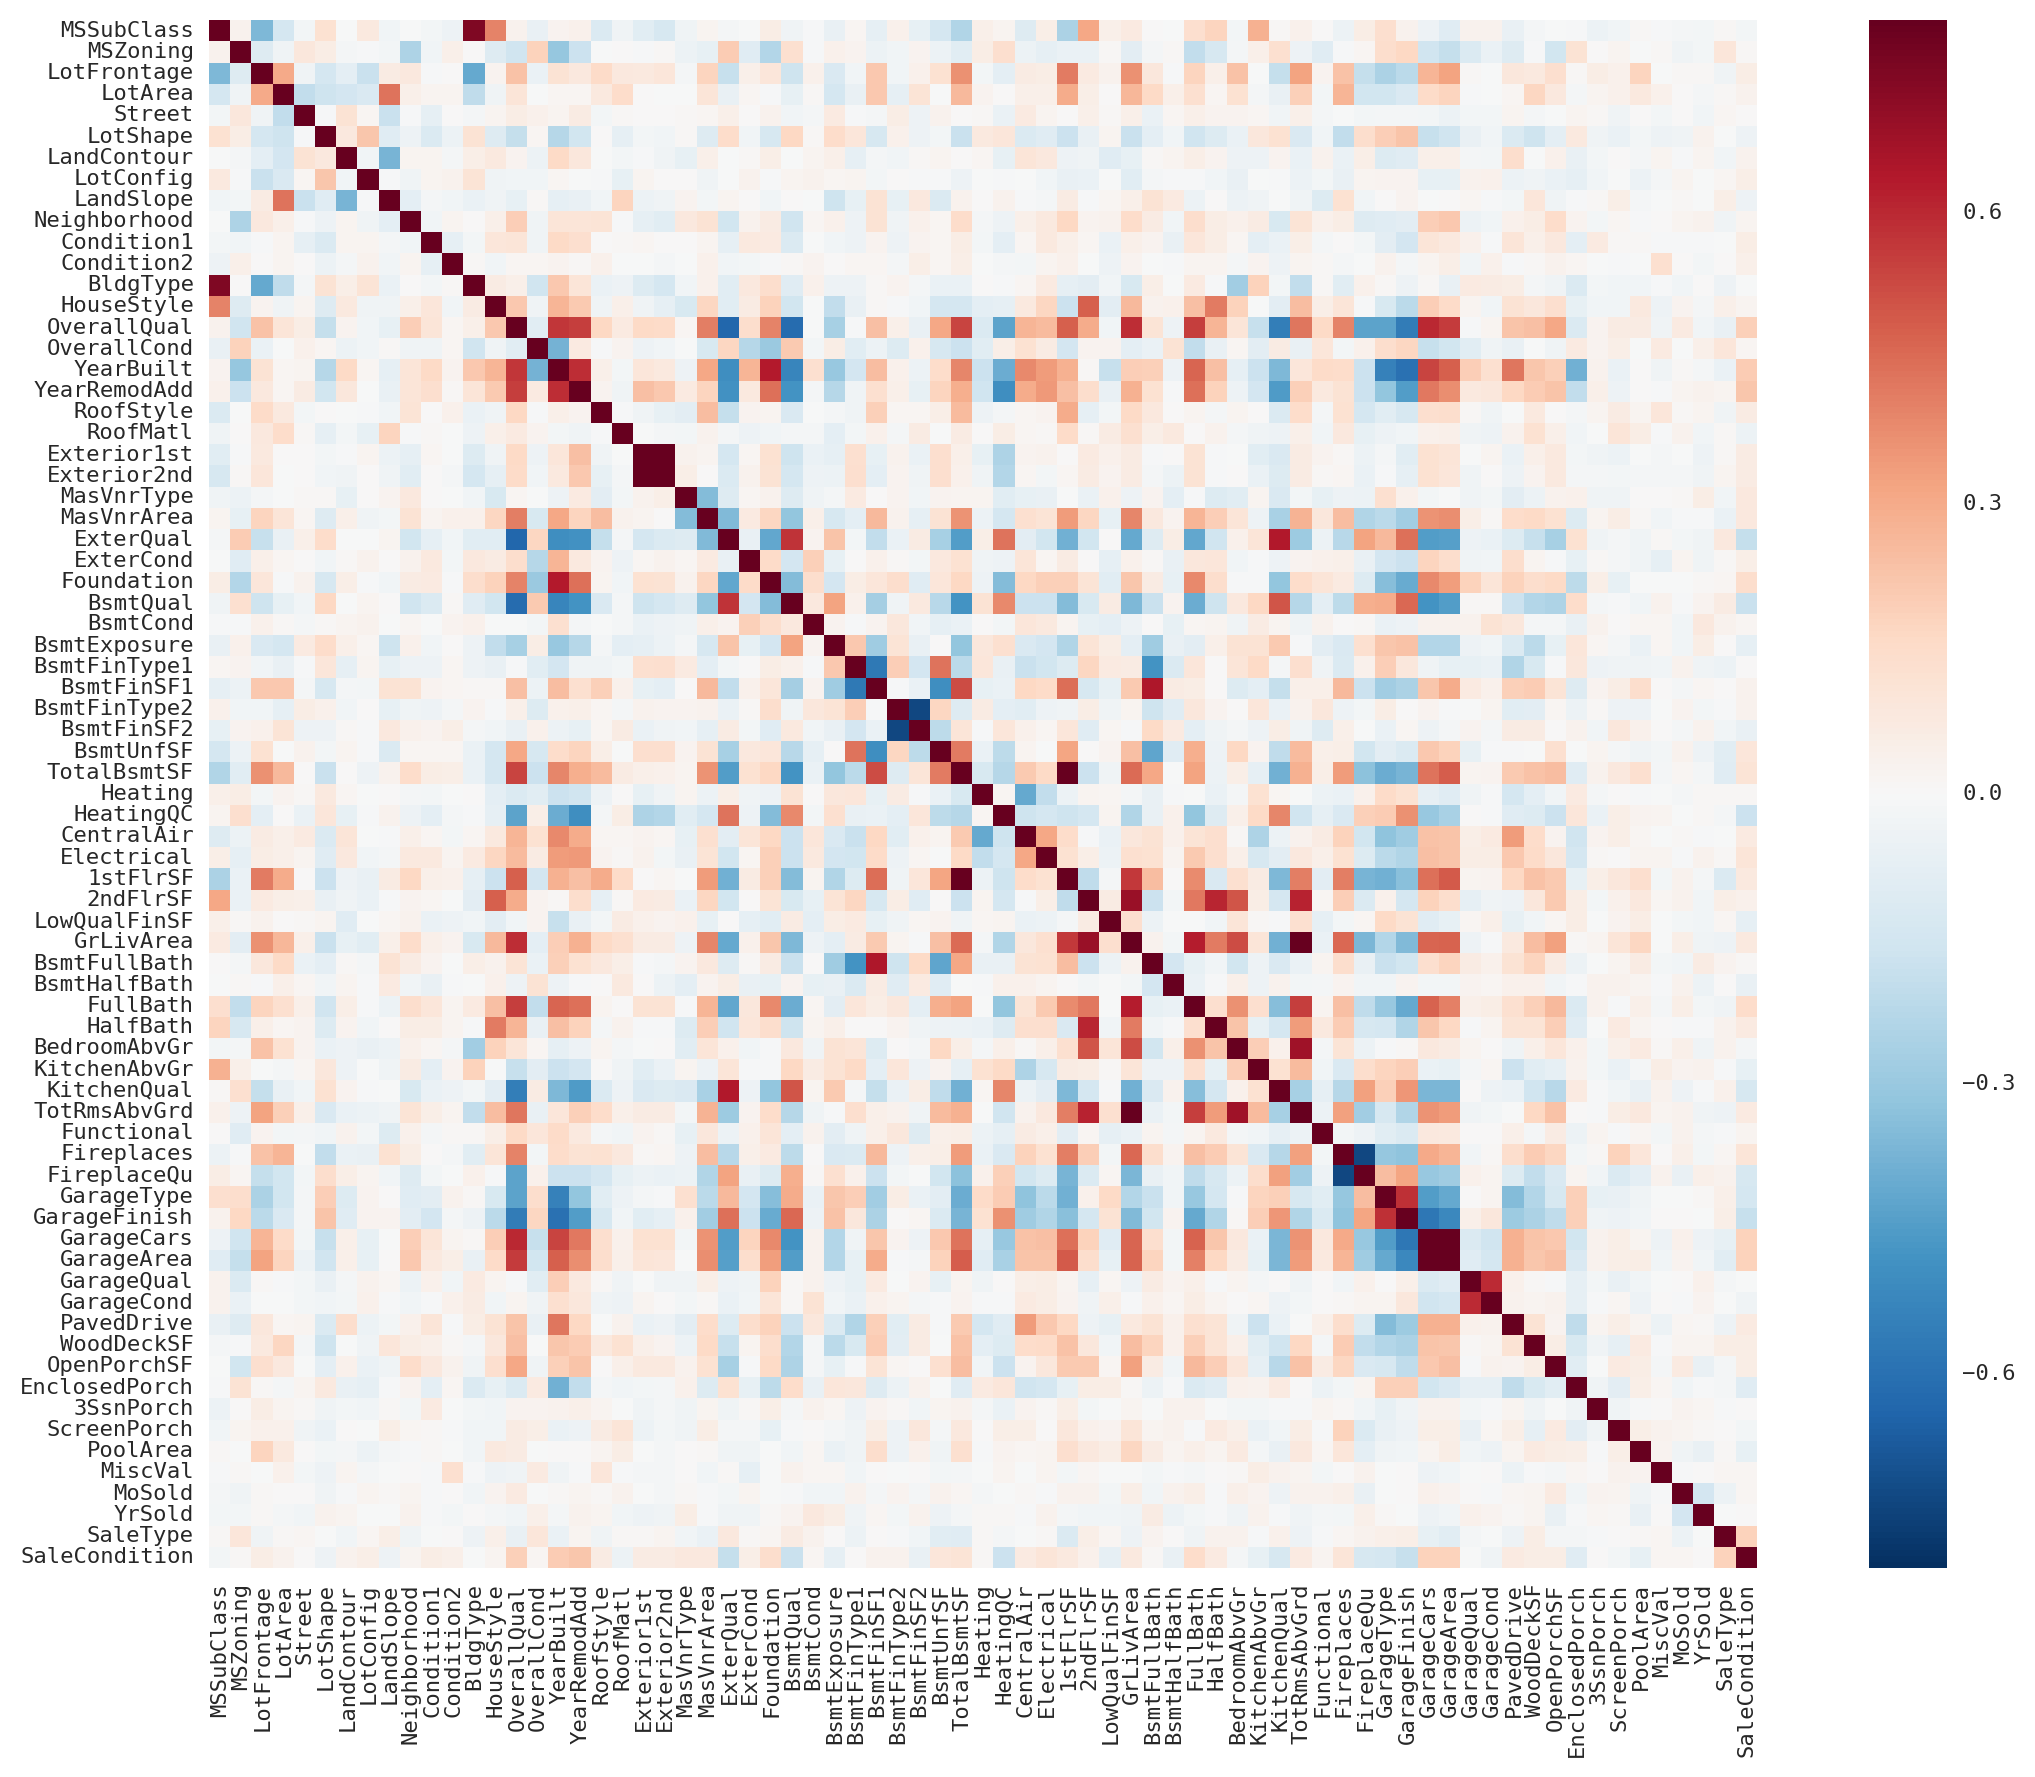

In [19]:
## check correlations:
sns.set(context="paper", font="monospace")

# Load the datset of correlations between cortical brain networks
corrmat = train.ix[:,:-1].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

# Use matplotlib directly to emphasize known networks
f.tight_layout()

In [84]:
## Correlation is not very bad
for i in range(len(train.ix[:,:-1].columns)):
    columni = train.columns[i]
    for j in range(i+1,len(train.ix[:,:-1].columns)-i):
        columnj = train.columns[j]
        corij = np.corrcoef(train[columni],train[columnj])[0,1]
        if corij > 0.5:
            print("%s is %s correlated with %s" % 
                  (columni,corij,columnj))

MSSubClass is 0.746062935988 correlated with BldgType
OverallQual is 0.572322768962 correlated with YearBuilt
OverallQual is 0.550683924194 correlated with YearRemodAdd
OverallQual is 0.537808498612 correlated with TotalBsmtSF
OverallQual is 0.593007430029 correlated with GrLivArea
OverallQual is 0.550599709368 correlated with FullBath
OverallQual is 0.600670716591 correlated with GarageCars
OverallQual is 0.562021756613 correlated with GarageArea
YearBuilt is 0.592854976344 correlated with YearRemodAdd
YearBuilt is 0.634841943264 correlated with Foundation
Exterior1st is 0.854162983733 correlated with Exterior2nd
ExterQual is 0.578014642451 correlated with BsmtQual
BsmtFinSF1 is 0.522396051992 correlated with TotalBsmtSF


In [ ]:
## Overall quality is highly correlated with Built Year, Year RemodAdd, Total basement area, 
## Above grade (ground) living area square feet, Full bathrooms above grade,GarageCars
## GarageArea

In [32]:
## Now we notice variation in some features is quite low. We wanna remove features with low variation
selector = VarianceThreshold(0.8)
train_reduced = pd.DataFrame(selector.fit_transform(train),columns = train.columns[selector.get_support()])
test_reduced = pd.DataFrame(selector.fit_transform(test),columns = test.columns[selector.get_support()])

In [33]:
train_reduced.shape

(1460, 46)

In [34]:
print('Now we only have %d features' % len(test_reduced.columns))

Now we only have 45 features


In [124]:
print("Features we remove are %s" % train.columns[~selector.get_support()])

Features we remove are Index(['MSZoning', 'Street', 'LandContour', 'LandSlope', 'Condition1',
       'Condition2', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtCond', 'Heating', 'CentralAir',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'GarageFinish',
       'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive'],
      dtype='object')


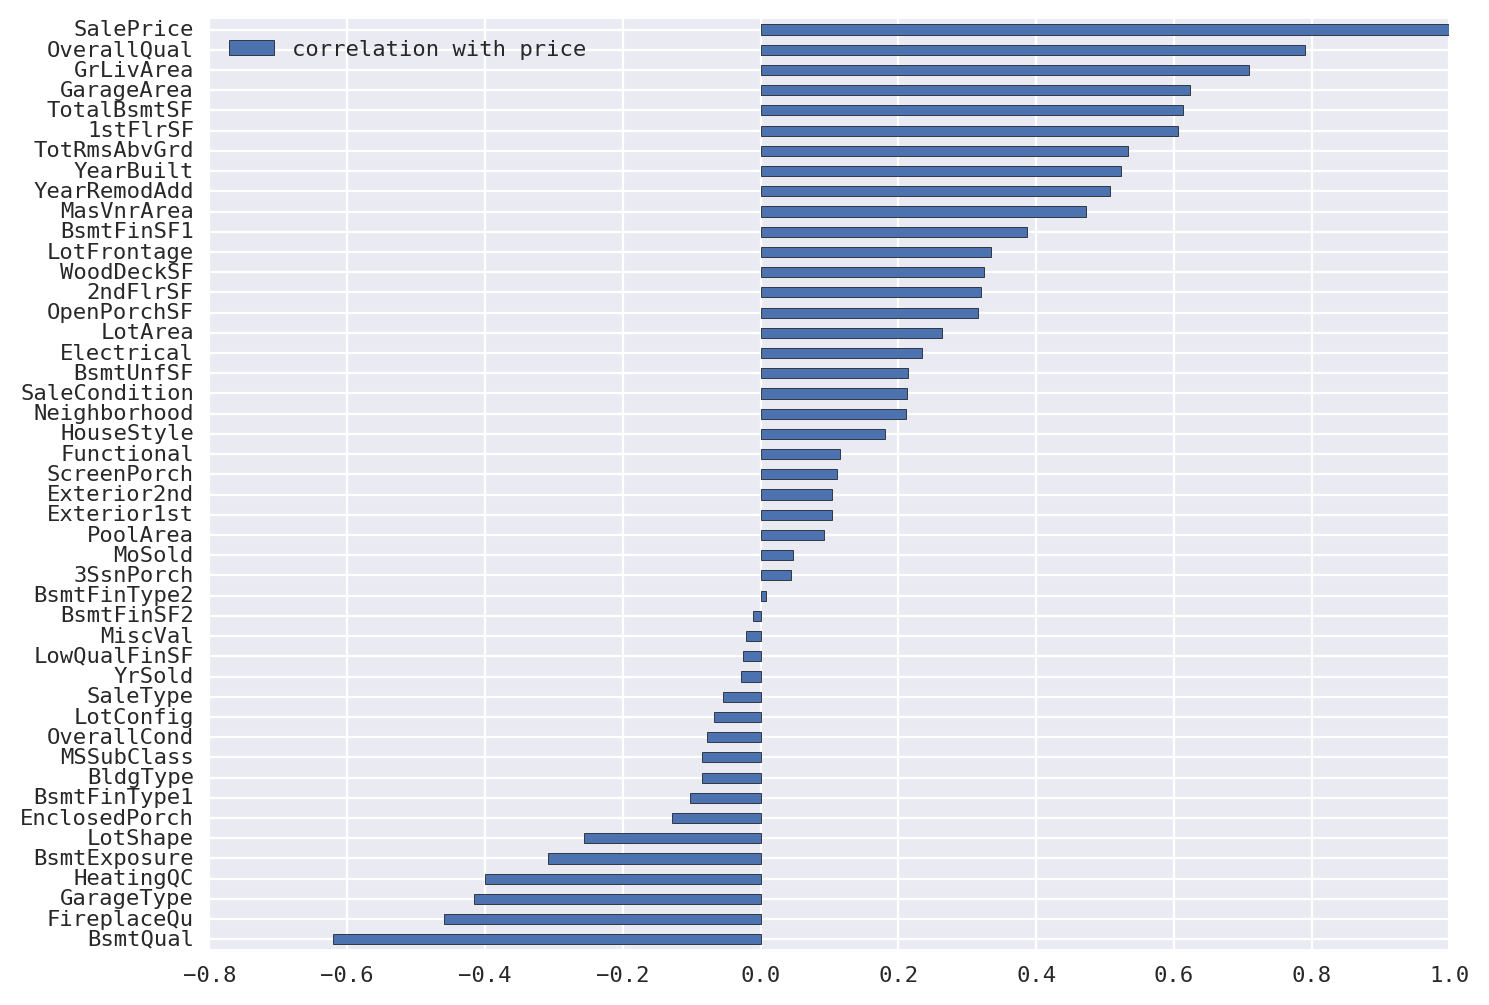

In [34]:
## Now let's see feature contribution

corr_price = dict()
for col in train_reduced.columns:
    corr_price[col] = np.corrcoef(train_reduced[col],train_reduced['SalePrice'])[0,1]
fig = pd.DataFrame.from_dict(data = corr_price,orient = 'index').sort_values(by = 0).plot(
    kind = 'barh',figsize = (8,6))
fig.legend(['correlation with price'],loc = 'best')

In [36]:
train_reduced.shape

(1460, 46)

In [69]:
### random forest

def rmse_cv(estimator, X, y):
    rmse= np.sqrt(-cross_val_score(estimator, X, y, scoring="neg_mean_squared_error"))
    return(rmse)

X = train_reduced.ix[:,:-1]
y = train_reduced.ix[:,-1]
forest = RandomForestClassifier(n_estimators = 100,max_features = 2,max_depth = None)
cv = ShuffleSplit(X.shape[0],test_size=0.1)
scores_RF_new = cross_val_score(forest,X,y,cv=cv,scoring = rmse_cv) 

MemoryError: 

In [ ]:
forest_new.fit(X_new,Y_new)
importances_allfeatures_new = forest_new.feature_importances_
importances_allfeatures_new[:10]
                                                                 
feature_imp = forest.feature_importances_
print(feature_imp)

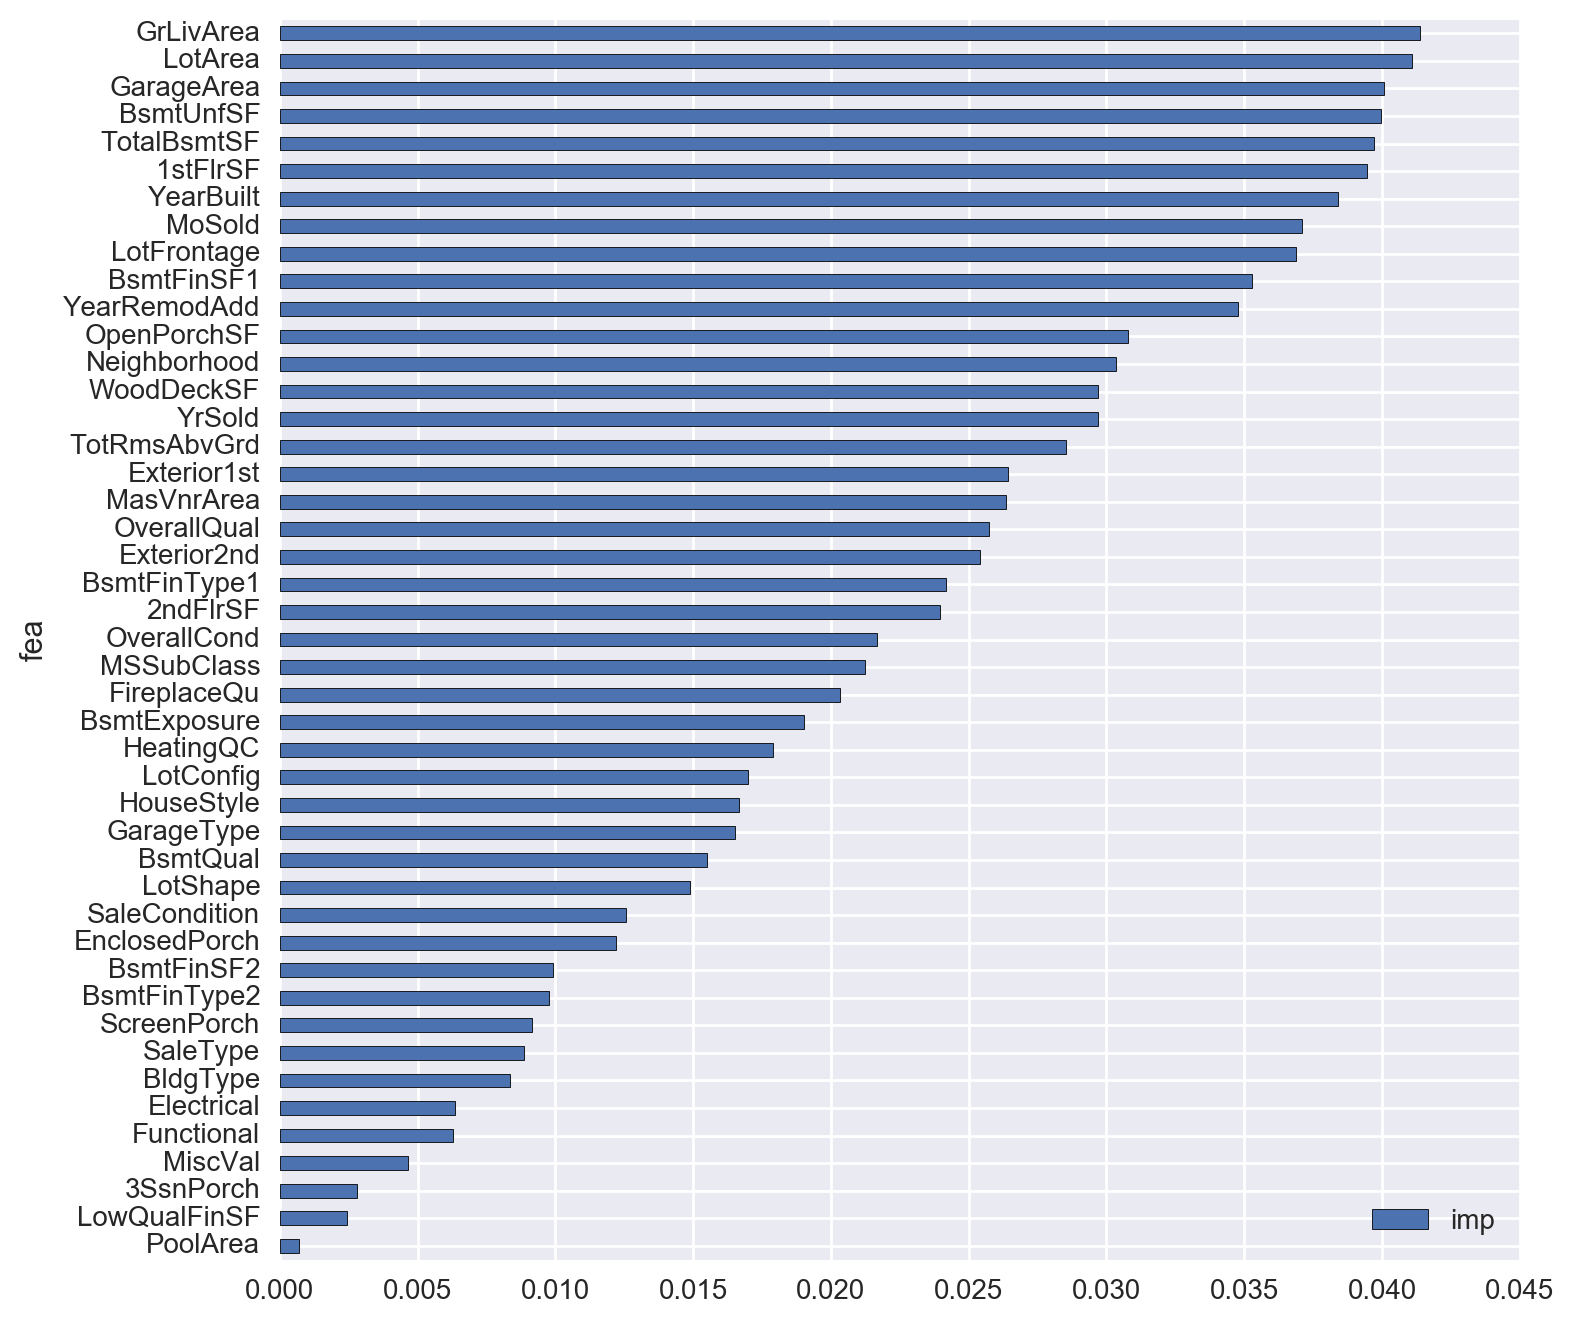

In [57]:
pd.DataFrame.from_dict({'imp':feature_imp,'fea':train_reduced.columns[:-1]}).set_index('fea').sort_values('imp').plot(
    kind = 'barh',figsize = (8,8))

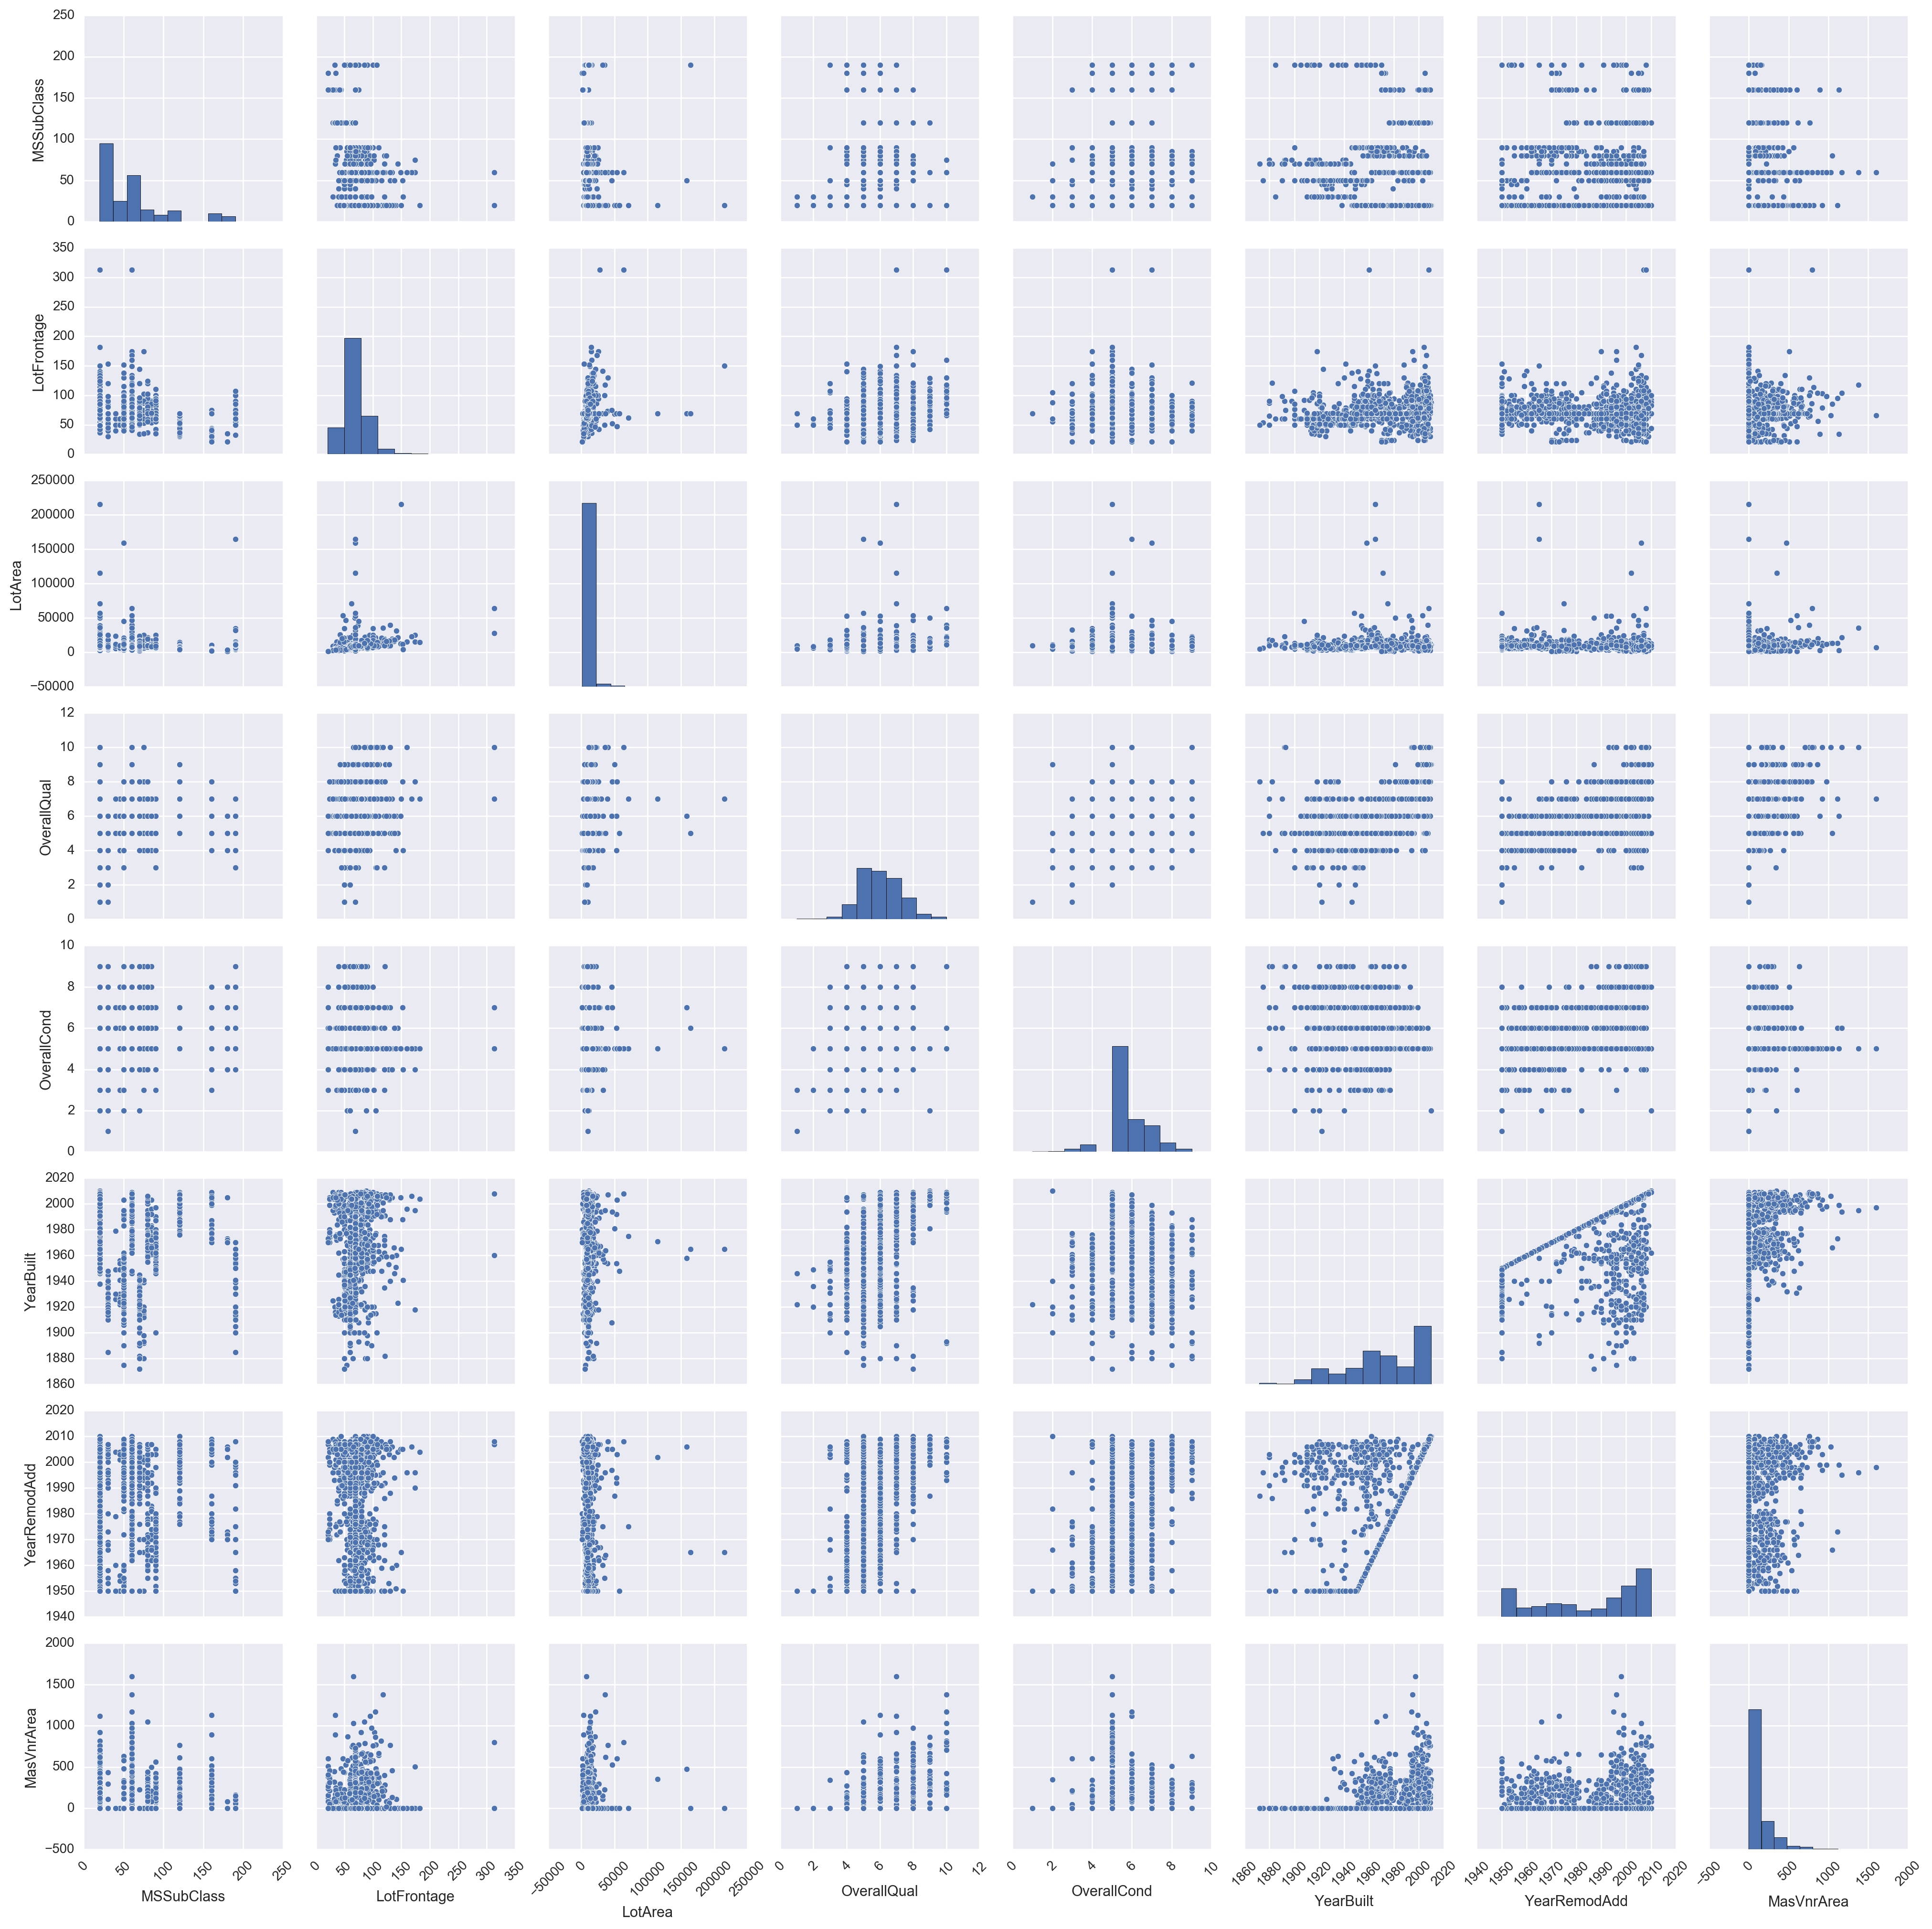

In [18]:
g = sns.pairplot(train[(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea'])], diag_kind="hist")
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(),rotation=45)

MSSubClass is 0.30788572076 correlated with 2ndFlrSF
MSSubClass is 0.444510654803 correlated with BldgType_2fmCon
MSSubClass is 0.415158527613 correlated with BldgType_Twnhs
MSSubClass is 0.524847172735 correlated with BldgType_TwnhsE
MSSubClass is 0.348910263079 correlated with HouseStyle_2Story
LotFrontage is 0.304522170744 correlated with LotArea
LotFrontage is 0.363472311641 correlated with TotalBsmtSF
LotFrontage is 0.413772532438 correlated with 1stFlrSF
LotFrontage is 0.368007439154 correlated with GrLivArea
LotFrontage is 0.320517656206 correlated with TotRmsAbvGrd
LotFrontage is 0.323510928812 correlated with GarageArea
LotFrontage is 0.33477085314 correlated with SalePrice
LotFrontage is 0.323090525294 correlated with MSZoning_RL
LotFrontage is 0.37063966903 correlated with BldgType_1Fam
LotArea is 0.359474567303 correlated with LandContour_Low
LotArea is 0.540379788506 correlated with LandSlope_Sev
OverallQual is 0.572322768962 correlated with YearBuilt
OverallQual is 0.5506

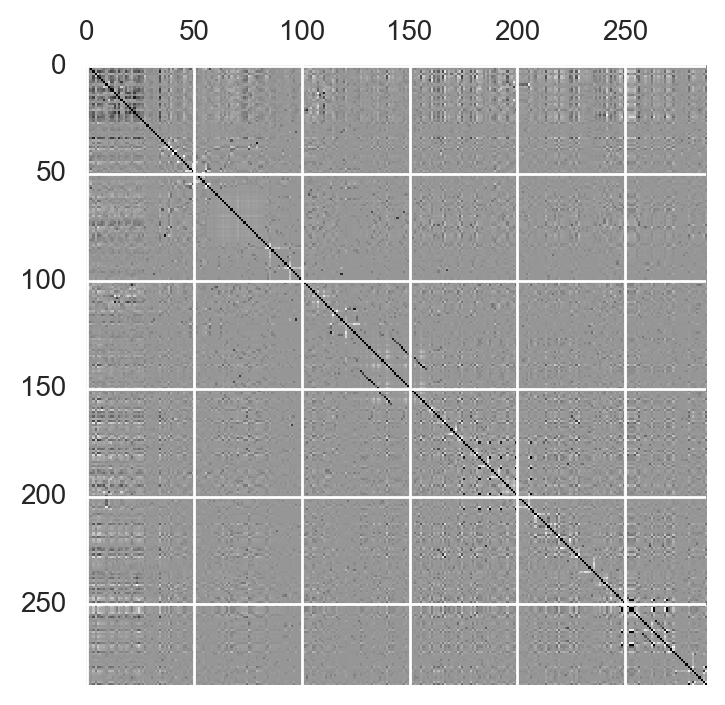

In [23]:
for i in range(len(train_dummies.columns.tolist())):
    columni = train_dummies.columns.tolist()[i]
    for j in range(i+1,len(train_dummies.columns.tolist())-i):
        columnj = train_dummies.columns.tolist()[j]
        corij = np.corrcoef(train_dummies[columni],train_dummies[columnj])[0,1]
        if corij>=0.3:
            print("%s is %s correlated with %s" % 
                  (train_dummies.columns.tolist()[i],corij,train_dummies.columns.tolist()[j]))
      
plt.matshow(train_dummies.corr())
plt.show()
plt.close()

In [98]:
train_dummies = pd.get_dummies(train)
test_dummies = pd.get_dummies(test)

In [99]:
train_dummies.shape

(1460, 288)

In [100]:
test_dummies.shape

(1459, 273)

In [105]:
## there are some features in train set not in test set. We need to throw them. We can only use 
## features appear in both set

features_avail = [col for col in train_dummies if col in test_dummies]
X = train_dummies[features_avail]
print(X.shape)
y = train_dummies['SalePrice']
print(y.shape)
T = test_dummies[features_avail]

print(T.shape)

(1460, 272)
(1460,)
(1459, 272)


In [127]:
from sklearn import preprocessing
X_normalized = preprocessing.normalize(X)
T_normalized = preprocessing.normalize(T)

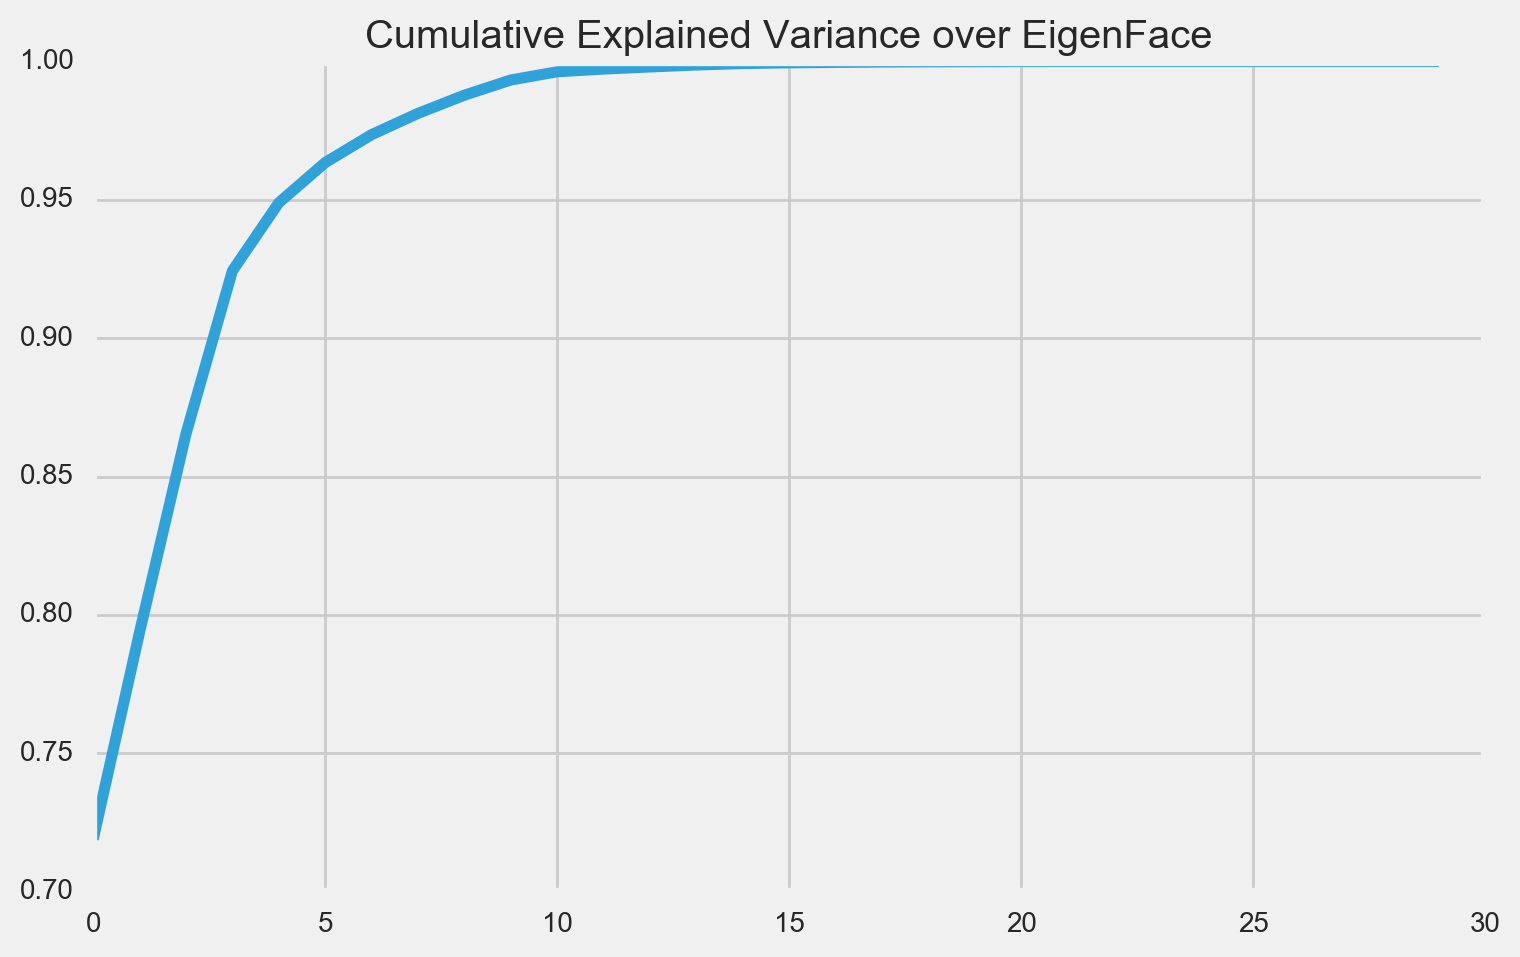

In [129]:
from sklearn import decomposition

n_eigens=30
X_reduced = decomposition.PCA(n_components=n_eigens).fit(X_normalized)
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(8, 5));
    plt.title('Cumulative Explained Variance over EigenFace');
    plt.plot(X_reduced.explained_variance_ratio_.cumsum());

In [130]:
X_reduced = decomposition.PCA(n_components=10).fit_transform(X_normalized)
T_reduced = decomposition.PCA(n_components=10).fit_transform(T_normalized)

In [120]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model,X_train,y):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [134]:
from sklearn import neighbors

n_neighbors = 5

knn = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
print(rmse_cv(knn,X_normalized,y))

[ 43188.54061887  41945.701274    47748.85054399  37629.87783641
  52097.79190402]


In [146]:
knn.fit(X_normalized,y)
knn.predict(X_normalized)

array([ 208500.,  181500.,  223500., ...,  266500.,  142125.,  147500.])

In [201]:
test.ix[pd.isnull(test['Utilities'])]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,Reg,Lvl,NaN,Inside,...,24,0,0,0,0,0,3,2009,ConLD,Normal
485,1946,20,RL,NaN,31220,Pave,IR1,Bnk,NaN,FR2,...,0,144,0,0,0,750,5,2008,WD,Normal


In [98]:
pd.DataFrame(train.isnull().sum(),columns = ['missingVal']).query('missingVal>0').sort_values(by = 'missingVal',ascending = False)

,missingVal
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
MasVnrType,8
MasVnrArea,8
Electrical,1


In [120]:
type(np.nan)

float

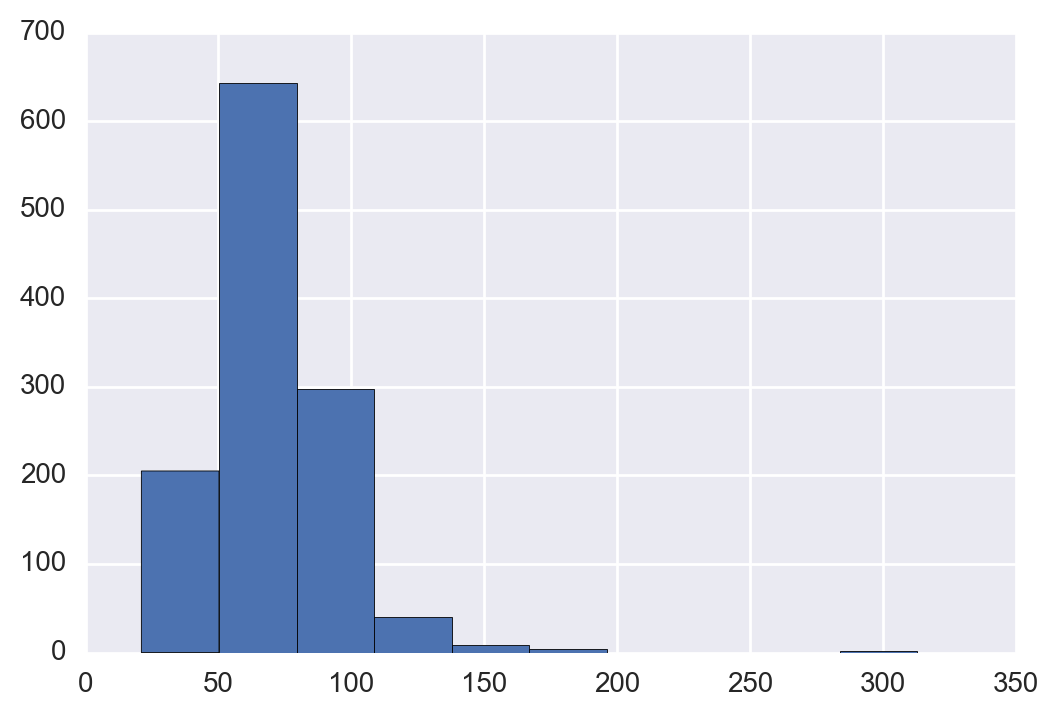

In [41]:
train['LotFrontage'].hist()

In [50]:
print(train['GarageYrBlt'].unique())
print('The newest house built in %d and the oldest built in %d'
      %(train['GarageYrBlt'].max(),train['GarageYrBlt'].min()))

[ 2003.  1976.  2001.  1998.  2000.  1993.  2004.  1973.  1931.  1939.
  1965.  2005.  1962.  2006.  1960.  1991.  1970.  1967.  1958.  1930.
  2002.  1968.  2007.  2008.  1957.  1920.  1966.  1959.  1995.  1954.
  1953.    nan  1983.  1977.  1997.  1985.  1963.  1981.  1964.  1999.
  1935.  1990.  1945.  1987.  1989.  1915.  1956.  1948.  1974.  2009.
  1950.  1961.  1921.  1900.  1979.  1951.  1969.  1936.  1975.  1971.
  1923.  1984.  1926.  1955.  1986.  1988.  1916.  1932.  1972.  1918.
  1980.  1924.  1996.  1940.  1949.  1994.  1910.  1978.  1982.  1992.
  1925.  1941.  2010.  1927.  1947.  1937.  1942.  1938.  1952.  1928.
  1922.  1934.  1906.  1914.  1946.  1908.  1929.  1933.]
The newest house built in 2010 and the oldest built in 1900


In [52]:
for col in cate_col_miss:
    print('%d classes in col %s'%(len(train[col].unique()), col))

7 classes in col GarageType
4 classes in col GarageFinish
6 classes in col GarageQual
6 classes in col GarageCond
5 classes in col BsmtExposure
7 classes in col BsmtFinType2
7 classes in col BsmtFinType1
5 classes in col BsmtCond
5 classes in col BsmtQual
5 classes in col MasVnrType
6 classes in col Electrical


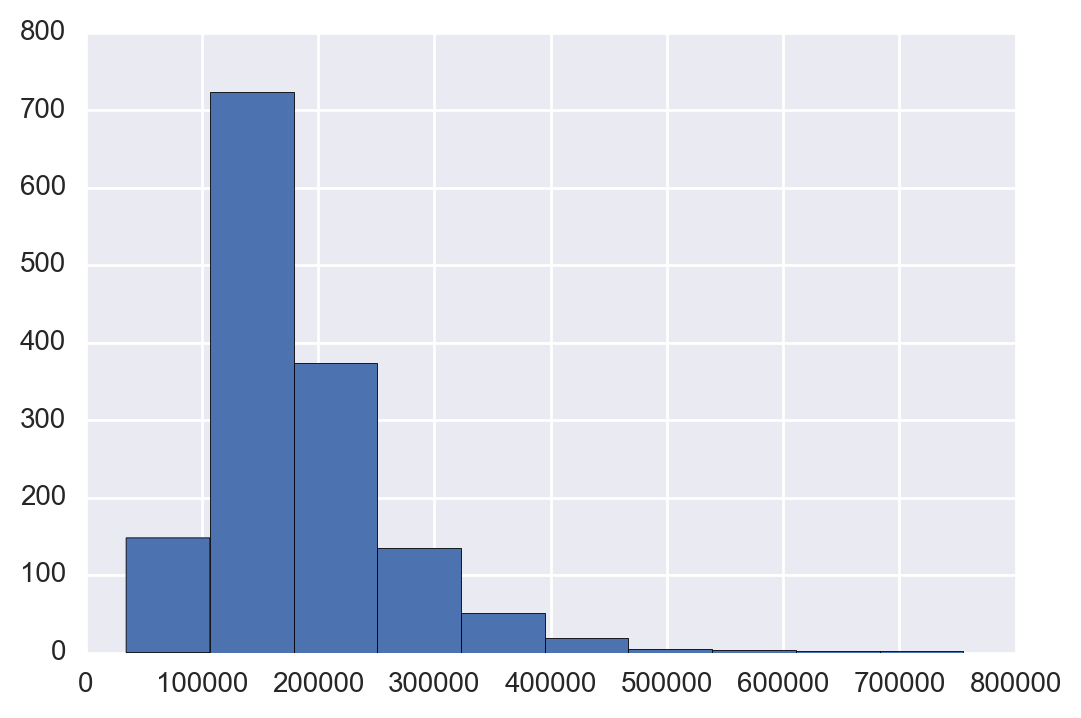

In [55]:
train['SalePrice'].hist()

In [60]:
train[train.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
5,6,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,...,0,320,0,0,700,10,2009,WD,Normal,143000
7,8,60,RL,NaN,10382,Pave,IR1,Lvl,AllPub,Corner,...,228,0,0,0,350,11,2009,WD,Normal,200000
10,11,20,RL,70.0,11200,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,129500
12,13,20,RL,NaN,12968,Pave,IR2,Lvl,AllPub,Inside,...,0,0,176,0,0,9,2008,WD,Normal,144000
14,15,20,RL,NaN,10920,Pave,IR1,Lvl,AllPub,Corner,...,176,0,0,0,0,5,2008,WD,Normal,157000
15,16,45,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Corner,...,0,0,0,0,0,7,2007,WD,Normal,132000
16,17,20,RL,NaN,11241,Pave,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,700,3,2010,WD,Normal,149000
17,18,90,RL,72.0,10791,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,500,10,2006,WD,Normal,90000
18,19,20,RL,66.0,13695,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,6,2008,WD,Normal,159000
